In [20]:
from matplotlib import pyplot as plt
import tfim_1d
from TFIM_generator import generate_TFIM_gates 
from qcels import *
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService as QRS
from qiskit_ibm_runtime import SamplerV2 as Sampler
import matplotlib
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 10

In [21]:
num_sites = 4
J = 1.0
g = 4

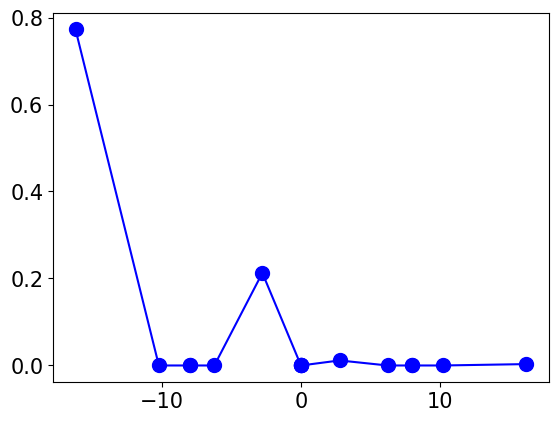

-16.255760712284413


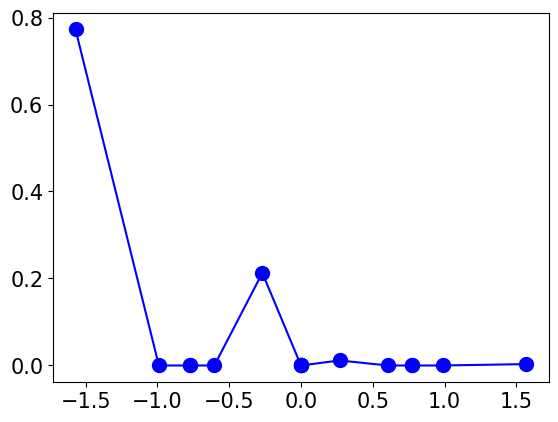

In [22]:
# calculate the ground state with g = 1
ham0 = tfim_1d.generate_ham(num_sites, J, 1.0)
ground_state_0 = ham0.eigh(subset_by_index = (0,0))[1][:,0] # g = 1 ground state


# plot original spectrum
ham = tfim_1d.generate_ham(num_sites, J, g)
eigenenergies, eigenstates = ham.eigh()
ground_state = eigenstates[:,0]
population_raw = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2
plt.plot(eigenenergies, population_raw, 'b-o')
plt.show()
print(eigenenergies[0])

old_ham = ham

# create modified spectrum
ham = modify_spectrum(old_ham)
eigenenergies, eigenstates = eigh(ham)

ground_state = eigenstates[:,0]
population = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2
plt.plot(eigenenergies, population, 'b-o')
plt.show()

In [4]:
computation_type = 'S'
output_file = True
p0_array            = np.array([0.9, 1]) # initial overlap with the first eigenvector
# p0_array            = np.arange(0.6, 0.99, 0.05)
trials              = 10 # number of comparisions each test (circuit depths)
tests               = 1
err_threshold       = 0.01
T0                  = 100

# QCELS variables
time_steps          = 5
epsilons            = np.array([0.1, 0.02, 0.009, 0.006, 0.003, 0.001, 0.0005, 0.0001, 0.00009, 0.00004])
iterations          = [int(np.log2(1/time_steps/i)) for i in epsilons]
err_QCELS           = np.zeros((len(p0_array),trials))
est_QCELS           = np.zeros((len(p0_array),trials))
cost_list_avg_QCELS = np.zeros((len(p0_array),trials))
rate_success_QCELS  = np.zeros((len(p0_array),trials))
max_T_QCELS         = np.zeros((len(p0_array),trials))

In [5]:
# initialization: S (Quantum Simulation), or R (Quantum Hardware)

if computation_type[0].upper() == 'S':
    print("\nQUANTUM SIMULATION SELECTED\n")

    backend = AerSimulator()
    data_name = "Q_Sim"

if computation_type[0].upper() == 'R':
    print("\nQUANTUM HARDWARE SELECTED\n")    
    
    # save qiskit API token for later use
    api_token = input("Enter API Token:")
    service = QRS(channel = 'ibm_quantum', instance='rpi-rensselaer/research/faulsf', token = api_token)
    backend = service.backend('ibm_rensselaer')
    data_name = "Q_Real"

if output_file:
    outfile = open("Output/"+str(data_name)+"_trans.txt", 'w')



QUANTUM SIMULATION SELECTED



In [6]:
# Transpiles circuits
for p in range(len(p0_array)):
    p0=p0_array[p]
    n_success_QCELS= np.zeros(trials)
    n_success_QPE= np.zeros(trials)

    print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")")

    if output_file: print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")", file = outfile)

    for test in range(tests):

        print("  Generating QCELS circuits", "(p0="+str(p0)+")","("+str(test+1)+"/"+str(tests)+")")

        #spectrum, population = generate_spectrum_population(eigenenergies, population_raw, [p0])

        #------------------QCELS-----------------
        Nsample = 100 # number of samples for constructing the loss function

        for trial in range(trials):
            print("    Transpiling QCELS", "("+str(trial+1)+"/"+str(trials)+")")
            epsilon = epsilons[trial]

            if output_file: print("    Transpiling QCELS", "("+str(trial+1)+"/"+str(trials)+")", file = outfile, flush = True)
            T = 1/epsilon
            for j in range(iterations[trial] + 1):
                tau = get_tau(j, time_steps, iterations[trial], T)
                qcs_QCELS = []
                #unitaries = []
                #unitaries.append(generate_TFIM_gates(num_sites, 1, 0, g, '../../../f3cpp'))
                unitaries = (generate_TFIM_gates(num_sites, time_steps, tau, g, '../../../f3cpp'))
                #unitaries = sum(unitaries, []) # flatten list
                for data_pair in range(time_steps):
                    t = tau*data_pair
                    mat = expm(-1j*ham*t)
                    controlled_U = UnitaryGate(mat).control(annotated="yes")
                    qcs_QCELS.append(create_HT_circuit(num_sites, controlled_U, W = 'Re', p0 = p0, backend = backend))
                    qcs_QCELS.append(create_HT_circuit(num_sites, controlled_U, W = 'Im', p0 = p0, backend = backend))
                with open('Transpiled_Circuits/QCELS_p0='+str(p0)+'_Test'+str(test)+'_Trial'+str(trial)+'_Iter='+str(j)+'.qpy', 'wb') as f:
                    qiskit.qpy.dump(qcs_QCELS, f)
        print('Finished transpiling for QCELS test '+str(test + 1))


Testing p0 = 0.9 (1/2)
  Generating QCELS circuits (p0=0.9) (1/1)
    Transpiling QCELS (1/10)
********************
***  TFYZ MODEL  ***
********************

  N = 4: timesteps = 5 , dt = 1

    hx = const value: 4
    Jy = const value: 0
    Jz = const value: 1

* timestep 1: hx = 4, Jz = 1
* timestep 2: hx = 4, Jz = 1
* timestep 3: hx = 4, Jz = 1
    - merge layer1
    - merge layer2
* timestep 4: hx = 4, Jz = 1
    - merge layer1
    - merge layer2
* timestep 5: hx = 4, Jz = 1
    - merge layer1
    - merge layer2

          ┌───┐                 ┌───┐┌─┐
  q1: ────┤ H ├──────────■──────┤ H ├┤M├
      ┌───┴───┴────┐┌────┴─────┐└───┘└╥┘
q2_0: ┤ Ry(0.9273) ├┤0         ├──────╫─
      ├────────────┤│          │      ║ 
q2_1: ┤ Ry(0.9273) ├┤1         ├──────╫─
      ├────────────┤│  Unitary │      ║ 
q2_2: ┤ Ry(0.9273) ├┤2         ├──────╫─
      ├────────────┤│          │      ║ 
q2_3: ┤ Ry(0.9273) ├┤3         ├──────╫─
      └────────────┘└──────────┘      ║ 
c0: 1/══════════════════

In [7]:
# Loads transpiled circuits
QCELS_depths = []

qcs_QCELS = []

for p in range(len(p0_array)):
    p0 = p0_array[p]
    QCELS_depths.append([])
    for test in range(tests):
        QCELS_depths[p].append([])
        for trial in range(trials):
            depth = 0
            print('Loading QCELS data ('+str(trial+1)+'/'+str(trials)+')')
            for i in range(iterations[trial] + 1):
                with open('Transpiled_Circuits/QCELS_p0='+str(p0)+'_Test'+str(test)+'_Trial'+str(trial)+'_Iter='+str(i)+'.qpy', 'rb') as f:
                    circs = qiskit.qpy.load(f)
                    for time_step in range(time_steps):
                        depth += circs[time_step].depth() 
                    qcs_QCELS.append(circs)

            QCELS_depths[p][test].append(depth)

qcs_QCELS = sum(qcs_QCELS, []) # flatten list

Loading QCELS data (1/10)
Loading QCELS data (2/10)
Loading QCELS data (3/10)
Loading QCELS data (4/10)
Loading QCELS data (5/10)
Loading QCELS data (6/10)
Loading QCELS data (7/10)
Loading QCELS data (8/10)
Loading QCELS data (9/10)
Loading QCELS data (10/10)
Loading QCELS data (1/10)
Loading QCELS data (2/10)
Loading QCELS data (3/10)
Loading QCELS data (4/10)
Loading QCELS data (5/10)
Loading QCELS data (6/10)
Loading QCELS data (7/10)
Loading QCELS data (8/10)
Loading QCELS data (9/10)
Loading QCELS data (10/10)


In [8]:
# Runs loaded circuits
print('Running transpiled circuits')
sampler = Sampler(backend)
jobs = sampler.run(qcs_QCELS, shots = T0)
results = jobs.result()

Running transpiled circuits


In [9]:
Z_ests = []
QCELS_times = []
init_lambdas = []
for p in range(len(p0_array)):
    Z_ests.append([])
    QCELS_times.append([])
    for test in range(tests):
        Z_ests[p].append([])
        QCELS_times[p].append([])
        for trial in range(trials):
            exec_time = 0
            Z_ests[p][test].append([])
            for iter in range(iterations[trial] + 1):
                Z_ests[p][test][trial].append([])
                for time_step in range(time_steps):
                    index = time_step*2 + iter*time_steps*2 + (sum(iterations[0:trial])+trial)*time_steps*2 + test*(sum(iterations)+len(iterations))*time_steps*2 + p*tests*(sum(iterations)+len(iterations))*time_steps*2
                    raw_data_re = results[index].data
                    counts_re = raw_data_re[list(raw_data_re.keys())[0]].get_counts()
                    raw_data_im = results[index + 1].data
                    counts_im = raw_data_im[list(raw_data_im.keys())[0]].get_counts()
                    exec_time += (0 + 1)

                    re_p0 = im_p0 = 0
                    if counts_re.get('0') is not None:
                        re_p0 = counts_re['0']/T0
                    if counts_im.get('0') is not None:
                        im_p0 = counts_im['0']/T0
                    #print('ReCounts', counts_re.get('0'), 'ImCounts', counts_im['0'])
                    
                    Re = 2*re_p0-1
                    Im = 2*im_p0-1 

                    Angle = np.arccos(Re)
                    if  np.arcsin(Im)<0:
                        Phase = 2*np.pi - Angle
                    else:
                        Phase = Angle

                    Z_est = complex(np.cos(Phase),np.sin(Phase))
                    
                    Z_ests[p][test][trial][iter].append(Z_est)
            QCELS_times[p][test].append(exec_time)

In [59]:
qr_ancilla = QuantumRegister(1)
qr_eigenstate = QuantumRegister(num_sites)
cr = ClassicalRegister(1)
qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
qc.h(qr_ancilla)
qc.x(qr_eigenstate)
#mat = expm(-1j*Ham*t)
#controlled_U = UnitaryGate(mat).control(annotated="yes")
unitary = generate_TFIM_gates(num_sites, 1, 0, 0, '../../../f3cpp')
qc.append(unitary[0], qargs = [qr_ancilla[:]] + qr_eigenstate[:])
qc.h(qr_ancilla)
qc.measure(qr_ancilla[0],cr[0])
trans_qc = transpile(qc, AerSimulator())

sampler = Sampler(backend)
jobs = sampler.run(qcs_QCELS, shots = 10000)
counts1 = jobs.result()[0].data[list(jobs.result()[0].data.keys())[0]].get_counts()


qr_ancilla = QuantumRegister(1)
qr_eigenstate = QuantumRegister(num_sites)
cr = ClassicalRegister(1)
qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
qc.h(qr_ancilla)
qc.x(qr_eigenstate)
#mat = expm(-1j*Ham*t)
#controlled_U = UnitaryGate(mat).control(annotated="yes")
qc.append(unitary[0], qargs = [qr_ancilla[:]] + qr_eigenstate[:] )
# if W = Imaginary
qc.sdg(qr_ancilla)
qc.h(qr_ancilla)
qc.measure(qr_ancilla[0],cr[0])
trans_qc = transpile(qc, AerSimulator())

sampler = Sampler(backend)
jobs = sampler.run(qcs_QCELS, shots = 10000)
counts2 = jobs.result()[0].data[list(jobs.result()[0].data.keys())[0]].get_counts()

********************
***  TFYZ MODEL  ***
********************

  N = 4: timesteps = 1 , dt = 0

    hx = const value: 0
    Jy = const value: 0
    Jz = const value: 1

* timestep 1: Jz = 1



In [60]:
print(counts1, counts2)

{'0': 4374, '1': 5626} {'1': 5618, '0': 4382}


In [67]:
re_p0 = im_p0 = 0
if counts1.get('0') is not None:
    re_p0 = counts1['0']/10000
if counts2.get('0') is not None:
    im_p0 = counts2['0']/10000
#print('ReCounts', counts_re.get('0'), 'ImCounts', counts_im['0'])

Re = 2*re_p0-1
Im = 2*im_p0-1 

Angle = np.arccos(Re)
if  np.arcsin(Im)<0:
    Phase = 2*np.pi - Angle
else:
    Phase = Angle

Z_est = complex(np.cos(Phase),np.sin(Phase))
print(Angle)
print(np.pi/2)

1.6963257415764232
1.5707963267948966


In [ ]:
matrix = expm(-1j*ham*1)
ctrl_U = UnitaryGate(matrix).control(annotated="yes")

tran_qc = create_HT_circuit(num_sites, ctrl_U, W = 'Re', p0 = 1, backend = AerSimulator())
sampler = Sampler(AerSimulator())
result = sampler.run([tran_qc], shots = 100000).result()
counts1 = result[0].data[str(list(result[0].data.keys())[0])].get_counts()

tran_qc = create_HT_circuit(num_sites, ctrl_U, W = 'Im', p0 = 1, backend = AerSimulator())
sampler = Sampler(AerSimulator())
result = sampler.run([tran_qc], shots = 100000).result()
counts2 = result[0].data[str(list(result[0].data.keys())[0])].get_counts()

re_p0 = im_p0 = 0
if counts1.get('0') is not None:
    re_p0 = counts1['0']/100000
if counts2.get('0') is not None:
    im_p0 = counts2['0']/100000
#print('ReCounts', counts_re.get('0'), 'ImCounts', counts_im['0'])

Re = 2*re_p0-1
Im = 2*im_p0-1 

Angle = np.arccos(Re)
if  np.arcsin(Im)<0:
    Phase = - Angle
else:
    Phase = Angle

lambda_prior = Angle

       ┌───┐            ┌───┐┌─┐
  q15: ┤ H ├─────■──────┤ H ├┤M├
       ├───┤┌────┴─────┐└───┘└╥┘
q16_0: ┤ H ├┤0         ├──────╫─
       ├───┤│          │      ║ 
q16_1: ┤ H ├┤1         ├──────╫─
       ├───┤│  Unitary │      ║ 
q16_2: ┤ H ├┤2         ├──────╫─
       ├───┤│          │      ║ 
q16_3: ┤ H ├┤3         ├──────╫─
       └───┘└──────────┘      ║ 
 c7: 1/═══════════════════════╩═
                              0 
       ┌───┐            ┌─────┐┌───┐┌─┐
  q17: ┤ H ├─────■──────┤ Sdg ├┤ H ├┤M├
       ├───┤┌────┴─────┐└─────┘└───┘└╥┘
q18_0: ┤ H ├┤0         ├─────────────╫─
       ├───┤│          │             ║ 
q18_1: ┤ H ├┤1         ├─────────────╫─
       ├───┤│  Unitary │             ║ 
q18_2: ┤ H ├┤2         ├─────────────╫─
       ├───┤│          │             ║ 
q18_3: ┤ H ├┤3         ├─────────────╫─
       └───┘└──────────┘             ║ 
 c8: 1/══════════════════════════════╩═
                                     0 
-0.5414197188637242


In [10]:
if output_file:
    outfile = open("Output/"+str(data_name)+"_run.txt", 'w')

for p in range(len(p0_array)):
    p0=p0_array[p]
    n_success_QCELS= np.zeros(trials)
    n_success_QPE= np.zeros(trials)

    print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")")

    if output_file: print("Testing p0 =", p0,"("+str(p+1)+"/"+str(len(p0_array))+")", file = outfile)

    for test in range(tests):

        print("  Generating QCELS and QPE data", "(p0="+str(p0)+")","("+str(test+1)+"/"+str(tests)+")")

        spectrum, population = generate_spectrum_population(eigenenergies, population_raw, [p0])

        #------------------QCELS-----------------
        Nsample = 100 # number of samples for constructing the loss function

        for trial in range(trials):
            print("    Running QCELS", "("+str(trial+1)+"/"+str(trials)+")")

            if output_file: print("    Running QCELS", "("+str(trial+1)+"/"+str(trials)+")", file = outfile, flush = True)
            epsilon = epsilons[trial]
            T = 1/epsilon
            lambda_prior = spectrum[0]
            ground_energy_estimate_QCELS, cosT_depth_list_this = qcels_largeoverlap_new(Z_ests[p][test][trial], time_steps, lambda_prior, T)
            #ground_energy_estimate_QCELS, cosT_depth_list_this, max_T_QCELS_this = qcels_largeoverlap()
            
            #cosT_depth_list_this = QCELS_depths[p][test][trial]
            max_T_QCELS_this = 0

            print("      Estimated ground state energy =", ground_energy_estimate_QCELS)
            if output_file: print("      Estimated ground state energy =", ground_energy_estimate_QCELS.x[2], file = outfile)

            est_this_run_QCELS = ground_energy_estimate_QCELS.x[2]
            #err_this_run_QCELS = np.abs(ground_energy_estimate_QCELS.x[2] - spectrum[0])
            err_this_run_QCELS = np.abs(ground_energy_estimate_QCELS.x[2] - lambda_prior)
            err_QCELS[p,trial] = err_QCELS[p,trial]+np.abs(err_this_run_QCELS)
            est_QCELS[p,trial] = est_QCELS[p,trial] + est_this_run_QCELS
            cost_list_avg_QCELS[p,trial]=cost_list_avg_QCELS[p,trial]+cosT_depth_list_this
            max_T_QCELS[p,trial]=max(max_T_QCELS[p,trial],max_T_QCELS_this)

            if np.abs(err_this_run_QCELS)<err_threshold:
                n_success_QCELS[trial]+=1

        print("    Finished QCELS data\n")
        if output_file: print("    Finished QCELS data\n", file = outfile)

    rate_success_QCELS[p,:] = n_success_QCELS[:]/tests
    err_QCELS[p,:] = err_QCELS[p,:]/tests
    est_QCELS[p,:] = est_QCELS[p,:]/tests
    cost_list_avg_QCELS[p,:]=cost_list_avg_QCELS[p,:]/tests

np.savez('Data/'+data_name+'_result_TFIM_8sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,name4=err_QCELS,name5=est_QCELS)
np.savez('Data/'+data_name+'_TFIM_8sites_data',name1=spectrum,name2=population,name3=ground_energy_estimate_QCELS.x[0],
        name4=ground_energy_estimate_QCELS.x[1],name5=ground_energy_estimate_QCELS.x[2])

print("Saved data to files starting with", data_name)
if output_file: print("Saved data to files starting with", data_name, file = outfile, flush=True)
outfile.close()
if output_file: print("Saved output to file ", "Output/"+str(data_name)+".txt")


Testing p0 = 0.9 (1/2)
  Generating QCELS and QPE data (p0=0.9) (1/1)
    Running QCELS (1/10)
      Preprocessing
      Starting Iteration (1/1)
      Finished Iterations
      Estimated ground state energy =  message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.22848444628836612
       x: [ 8.675e-01 -1.383e-01 -2.328e+00]
     nit: 9
     jac: [ 1.282e-04 -7.575e-04  9.637e-04]
    nfev: 38
    njev: 9
    Running QCELS (2/10)
      Preprocessing
      Starting Iteration (1/3)
      Starting Iteration (2/3)
      Starting Iteration (3/3)
      Finished Iterations
      Estimated ground state energy =  message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.17315142352367963
       x: [ 8.955e-01 -1.596e-01 -2.380e+00]
     nit: 5
     jac: [ 6.757e-04  1.217e-04 -5.701e-03]
    nfev: 24
    njev: 5
    Running QCELS (3/10)
      Preprocessing
      Starting Iteration (1/4)
      Starting Iteration (2/4)
      Starting Iter

/home/aweiss/Documents/quantum-phase-estimation-comparision/Quantum_Version/qcels.py:122: RuntimeWarning: divide by zero encountered in divide
  q[0:num_p] = p/(1-np.sum(p))*np.sum(q[num_p:])
/home/aweiss/Documents/quantum-phase-estimation-comparision/Quantum_Version/qcels.py:123: RuntimeWarning: invalid value encountered in divide
  return spectrum, q/np.sum(q)


In [11]:
lambda_prior

np.float64(-2.3561944901923444)

In [12]:
print(3*np.pi/4)

2.356194490192345
